# Obtaining of the Classifier

Despite the high prediction rate of the SVM technique in a wide range of real applications, the classification accuracy of the SVM highly depends on specifying the model parameters as well as selecting the subset of features. (https://www.sciencedirect.com/science/article/pii/S0957417422008144)

Gamma en C zijn nuttig voor lineair.
https://stackabuse.com/understanding-svm-hyperparameters/



# Code preparation

In this part of the code, the google colab is linked to the github.

In [2]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/NFAFrijns/TM10007_G1_lipo.git


  Preparing metadata (setup.py) ... done


## Data loading and cleaning

Below are functions to load the dataset.

**The first 5 featurs are selected to be able to program the code. In the final code these 5 features would be imported from the dimensionality reduction.** *cursieve tekst*

Our data set contains more than 50 samples. The samples are categorized (liposarcoma and Lipoma) and labeled. Since we have less than 100k samples we are going to try the following predictors and see which works best:
*   Linear SVC
*   KNeighors classifier
*   SCV
*   Ensemble classifiers





##LinSVC Classifier (incl 5 fold validation loop)

We kiezen er hier voor om een 5-fold validation loop te doen. Dit kan natuurlijk ook een andere hoeveelheid zijn. **Dit doet hij over de hele 'train' data. Test data moet echt appart gehouden worden!!**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from statsmodels.stats.multitest import multipletests

data = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

N1 = 6;
N2 = 10;
N3 = 50;

# Encode target variable
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Compute F-statistics and p-values using f_classif
F_values, p_values = f_classif(X_train, y_train_encoded)

# Bonferroni correction on the p-values to correct for multiple testing
_, p_adjusted, _, alpha_corrected = multipletests(p_values, method='bonferroni')

# Create a DataFrame with feature names, F-values, and p-values
feature_stats_df = pd.DataFrame({'F-value': F_values, 'p-value': p_adjusted}, index=X_train.columns)

# Sort features based on absolute correlation values and select top 20
sorted_features_1 = feature_stats_df.abs().nlargest(N1, 'F-value')
sorted_features_2 = feature_stats_df.abs().nlargest(N2, 'F-value')
sorted_features_3 = feature_stats_df.abs().nlargest(N3, 'F-value')

# Maak nieuwe kleinere datasets met minder features
X_train_sel_6 = X_train.loc[:, sorted_features_1.index]
X_train_sel_10 = X_train.loc[:, sorted_features_2.index]
X_train_sel_50 = X_train.loc[:, sorted_features_3.index]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 76  77  85  90  96  97 103 422 423 435 436 448 449 467 474 475 480 487
 488] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
# Importing libraries
import pandas as pd
from worclipo.load_data import load_data
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# Import data
data = load_data()
feature_data = data.iloc[:, 1:7]

# Splitting data
y = data['label']  # Target data (Labels)
X = feature_data  # Feature data

# Define the grid of hyperparameters
param_grid1 = {
    'C': [0.1, 0.5, 1.0],  # Values for C
    'break_ties': [True, False],  # Values for break_ties
    'cache_size': [100, 200, 300],  # Values for cache_size
    'class_weight': [None, 'balanced'],  # Values for class_weight
    'coef0': [0.0, 0.5, 1.0],  # Values for coef0
    'decision_function_shape': ['ovo', 'ovr'],  # Values for decision_function_shape
    'degree': [2, 3, 4],  # Values for degree
    'gamma': ['scale', 'auto'],  # Values for gamma
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Values for kernel
    'max_iter': [100, 200, 300],  # Values for max_iter
    'probability': [True, False],  # Values for probability
    'shrinking': [True, False],  # Values for shrinking
    'tol': [0.001, 0.01, 0.1]  # Values for tol
}

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

number_of_features =  X_train.shape[1]
features_variance = X_train.values.var()
gamma = 1/(number_of_features * features_variance)

param_grid = {'C': [1, 10, 100, 1000],
              'kernel': ['linear']
}

# Build SVM model
SVM_Model = SVC()

# Perform grid search
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv=cv)
grid.fit(X_train, y_train)

# Get the best average performance over the folds
cv_results = grid.cv_results_
avg_scores = cv_results['mean_test_score']
best_index = avg_scores.argmax() # Find the index of the best average score
best_params = cv_results['params'][best_index]
print("Best hyperparameters:", best_params)

# Evaluate the model with best hyperparameters on the test set
best_model = grid.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy with best hyperparameters:", test_accuracy)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ................C=1, kernel=linear;, score=0.581 total time=   0.1s
[CV 2/3] END ................C=1, kernel=linear;, score=0.581 total time=   0.1s
[CV 3/3] END ................C=1, kernel=linear;, score=0.533 total time=   0.0s
[CV 1/3] END ...............C=10, kernel=linear;, score=0.548 total time=   0.4s
[CV 2/3] END ...............C=10, kernel=linear;, score=0.710 total time=   0.6s
[CV 3/3] END ...............C=10, kernel=linear;, score=0.667 total time=   0.5s
[CV 1/3] END ..............C=100, kernel=linear;, score=0.645 total time=  12.6s
[CV 2/3] END ..............C=100, kernel=linear;, score=0.806 total time=   6.0s
[CV 3/3] END ..............C=100, kernel=linear;, score=0.633 total time=   0.7s
[CV 1/3] END .............C=1000, kernel=linear;, score=0.548 total time=   6.9s
[CV 2/3] END .............C=1000, kernel=linear;, score=0.710 total time=  18.9s
[CV 3/3] END .............C=1000, kernel=linear;,

In [ ]:
import pandas as pd
import numpy as np
from worclipo.load_data import load_data
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

#Import data
data = load_data()
feature_data = data.iloc[:, :7] #Hier moeten dus de feature data komen

#Splitting data --> Dit doet hij over de hele 'train' data. Test data moet echt appart gehouden worden!!
X = feature_data.iloc[:, 2:]  # Feature data
y = feature_data['label']     # Labels

clf_randFor = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores_randFor = cross_val_score(clf_randFor, X, y, cv=5)
print("Cross-validated accuracy scores:", scores_randFor)
print("Mean accuracy:", scores_randFor.mean())

Cross-validated accuracy scores: [0.69565217 0.60869565 0.52173913 0.73913043 0.65217391]
Mean accuracy: 0.6434782608695653


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

#Import data
data = load_data()
feature_data = data.iloc[:, :7] #Hier moeten dus de feature data komen

#Splitting data --> Dit doet hij over de hele 'train' data. Test data moet echt appart gehouden worden!!
X = feature_data.iloc[:, 2:]  # Feature data
y = feature_data['label']     # Labels

#Create classifier
clf_bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
scores_bagging = cross_val_score(clf_bagging, X, y, cv=5)
print("Cross-validated accuracy scores:", scores_bagging)
print("Mean accuracy:", scores_bagging.mean())

Cross-validated accuracy scores: [0.47826087 0.39130435 0.52173913 0.60869565 0.56521739]
Mean accuracy: 0.5130434782608695


## Reset

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 75  76  84  89  95  96 102 421 422 434 435 447 448 466 473 474 479 486
 487] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


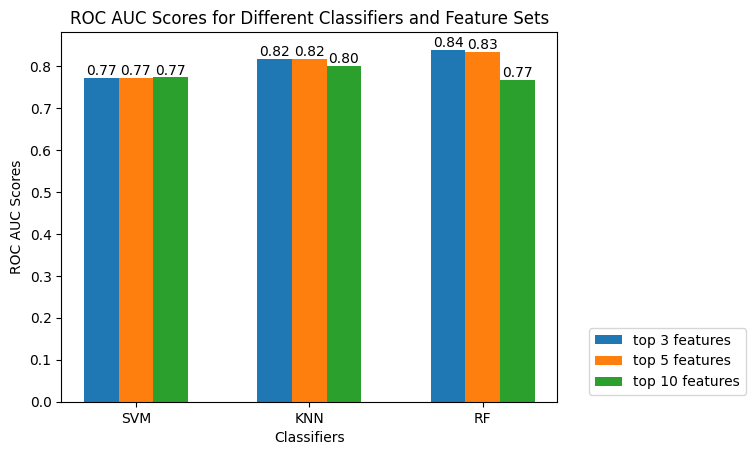

In [ ]:
# Importing libraries
import pandas as pd
from worclipo.load_data import load_data
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from worclipo.load_data import load_data
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from statsmodels.stats.multitest import multipletests



#INLADEN DATA
data = load_data()
X = data.iloc[:, 2:]  # Feature data
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



#FEATURE SELECTION
N1 = 3;
N2 = 5;
N3 = 10;

# Encode target variable
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Compute F-statistics and p-values using f_classif
F_values, p_values = f_classif(X_train, y_train_encoded)

# Bonferroni correction on the p-values to correct for multiple testing
_, p_adjusted, _, alpha_corrected = multipletests(p_values, method='bonferroni')

# Create a DataFrame with feature names, F-values, and p-values
feature_stats_df = pd.DataFrame({'F-value': F_values, 'p-value': p_adjusted}, index=X_train.columns)

# Sort features based on absolute correlation values and select top 20
sorted_features_1 = feature_stats_df.abs().nlargest(N1, 'F-value')
sorted_features_2 = feature_stats_df.abs().nlargest(N2, 'F-value')
sorted_features_3 = feature_stats_df.abs().nlargest(N3, 'F-value')

# Maak nieuwe kleinere datasets met minder features
X_train_sel_6 = X_train.loc[:, sorted_features_1.index]
X_train_sel_10 = X_train.loc[:, sorted_features_2.index]
X_train_sel_15 = X_train.loc[:, sorted_features_3.index]



# Non-optimalized Classifier comparison (5-fold crossvalidation)
classifiers = [SVC(), KNeighborsClassifier(), RandomForestClassifier()]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

score_lists = {}

for X_train_sel, n_features in zip([X_train_sel_6, X_train_sel_10, X_train_sel_50], [N1, N2, N3]):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score_list = []
    for cls in classifiers:
        rocauc = cross_val_score(cls, X_train_sel, y_train_encoded, scoring='roc_auc', cv=cv)
        mean = np.mean(rocauc)
        score_list.append(mean)

    score_lists[f'X_train_sel_{n_features}'] = score_list



# PLOTTEN (ROC AUC scores voor verschillende classifiers en aantal features)
classifiers_names = ['SVM', 'KNN', 'RF']
legend_labels = [f'top {N1} features', f'top {N2} features', f'top {N3} features']
n_datasets = len(score_lists)
width = 0.2  # breedte van elke balk
x = np.arange(len(classifiers_names))  # de x-coördinaten van de balken

fig, ax = plt.subplots()

for i, (dataset, scores) in enumerate(score_lists.items()):
    rects = ax.bar(x + i * width - (width * (n_datasets - 1) / 2), scores, width, label=legend_labels[i])  # Gebruik legend_labels voor de legenda
    for rect, score in zip(rects, scores):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{score:.2f}', ha='center', va='bottom')

ax.set_xlabel('Classifiers')
ax.set_ylabel('ROC AUC Scores')
ax.set_title('ROC AUC Scores for Different Classifiers and Feature Sets')
ax.set_xticks(x)
ax.set_xticklabels(classifiers_names)
ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 75  76  84  89  95  96 102 421 422 434 435 447 448 466 473 474 479 486
 487] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 75  76  84  89  95  96 102 421 422 434 435 447 448 466 473 474 479 486
 487] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selectio

Max N value for LinSVM: 33
Max N value for K-NN: 1
Max N value for RF: 2


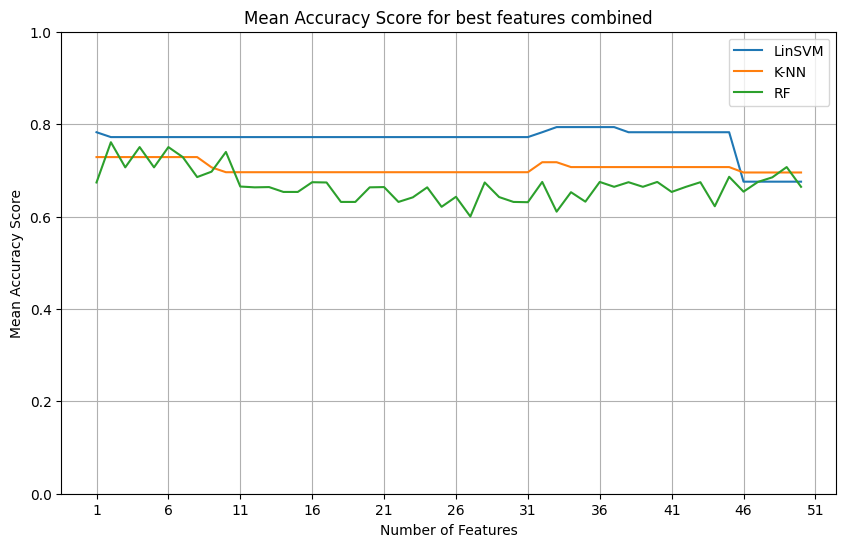

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from worclipo.load_data import load_data
from statsmodels.stats.multitest import multipletests

#INLADEN DATA
data = load_data()
X = data.iloc[:, 2:]  # Feature data
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

def select_top_features(X_train, y_train_encoded, N):
    F_values, _ = f_classif(X_train, y_train_encoded)
    feature_stats_df = pd.DataFrame({'F-value': F_values}, index=X_train.columns)
    sorted_features = feature_stats_df.abs().nlargest(N, 'F-value')
    X_train_sel = X_train.loc[:, sorted_features.index]

    return X_train_sel, y_train_encoded

# Definiëren
N_values = range(1, 51)
classifiers = [SVC(), KNeighborsClassifier(), RandomForestClassifier()]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialisatie van de lijsten voor het opslaan van resultaten
mean_scores = {cls.__class__.__name__: [] for cls in classifiers}
std_scores = {cls.__class__.__name__: [] for cls in classifiers}

# Itereren over verschillende N-waarden
for N in N_values:
    # Feature selectie
    X_train_sel, y_train_encoded = select_top_features(X_train, y_train_encoded, N)

    # Scores voor elke classifier berekenen
    for cls in classifiers:
        scores = cross_val_score(cls, X_train_sel, y_train_encoded, scoring='accuracy', cv=cv)  # Hier de scoring veranderd
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        mean_scores[cls.__class__.__name__].append(mean_score)
        std_scores[cls.__class__.__name__].append(std_score)

#Bepalen beste aantal features
max_accuracy_SVM = max(mean_scores['SVC'])
N_SVM = N_values[mean_scores['SVC'].index(max_accuracy_SVM)]

max_accuracy_KNN = max(mean_scores['KNeighborsClassifier'])
N_KNN = N_values[mean_scores['KNeighborsClassifier'].index(max_accuracy_KNN)]

max_accuracy_RF = max(mean_scores['RandomForestClassifier'])
N_RF = N_values[mean_scores['RandomForestClassifier'].index(max_accuracy_RF)]

# Printen van de resultaten
print("Max N value for LinSVM:", N_SVM)
print("Max N value for K-NN:", N_KNN)
print("Max N value for RF:", N_RF)


# Plotten van de resultaten
plt.figure(figsize=(10, 6))

for cls in classifiers:
    plt.plot(N_values, mean_scores[cls.__class__.__name__], label=cls.__class__.__name__)

plt.xlabel('Number of Features')
plt.ylabel('Mean Accuracy Score')
plt.title('Mean Accuracy Score for best features combined')
plt.xticks(np.arange(1, 52, 5))
plt.ylim(0, 1)
plt.legend(['LinSVM', 'K-NN', 'RF'])
plt.grid(True)
plt.show()


# Greedy feature selection

In [23]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from worclipo.load_data import load_data
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

#INLADEN DATA
data = load_data()
X = data.iloc[:, 2:]  # Feature data
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Selecting top 50 features
def select_top_features(X_train, y_train_encoded, N):
    F_values, _ = f_classif(X_train, y_train_encoded)
    feature_stats_df = pd.DataFrame({'F-value': F_values}, index=X_train.columns)
    sorted_features = feature_stats_df.abs().nlargest(N, 'F-value')
    X_train_sel = X_train.loc[:, sorted_features.index]

    return X_train_sel, y_train_encoded

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

N = 10
X_top50, y_top50 = select_top_features(X_train, y_train_encoded, N)

#Forward greedy feature selection
Classifier_Model = KNeighborsClassifier()

def forward_greedy_selection(X_top50, y_top50, Classifier_Model):
    features = list(X_top50.columns)
    remaining_features = features.copy()
    selected_features = []
    accuracies = []
    model = Classifier_Model

    while len(remaining_features) > 0:
        accuracies = []  # Reset the accuracies list at the beginning of each iteration
        for feature in remaining_features:
            temp_selected_features = selected_features + [feature]
            X_train_sel = X_top50[temp_selected_features]
            model.fit(X_train_sel, y_top50)
            y_pred = model.predict(X_train_sel)
            accuracy = accuracy_score(y_top50, y_pred)
            accuracies.append(accuracy)

        # Determine which feature to add
        best_feature_index = np.argmax(accuracies)
        best_feature = remaining_features.pop(best_feature_index)

        # Update selected features
        selected_features.append(best_feature)

    X_train_sel = X_top50[selected_features]
    return X_train_sel, y_top50

X_selected_features, y_selected_features = forward_greedy_selection(X_top50, y_top50, Classifier_Model)
print(X_selected_features)
print(y_selected_features)




/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 75  76  84  89  95  96 102 421 422 434 435 447 448 466 473 474 479 486
 487] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


            PREDICT_original_sf_volume_2.5D  \
ID                                            
Lipo-032_0                     1.404000e+05   
Lipo-068_0                     1.172924e+06   
Lipo-094_0                     3.053620e+05   
Lipo-110_0                     3.675215e+05   
Lipo-023_0                     2.861175e+05   
...                                     ...   
Lipo-107_0                     5.608393e+04   
Lipo-015_0                     1.868795e+06   
Lipo-093_0                     1.982456e+04   
Lipo-052_0                     6.591165e+05   
Lipo-103_0                     6.649676e+05   

            PREDICT_original_tf_Gabor_energy_F0.2_A1.57  \
ID                                                        
Lipo-032_0                                 11251.335665   
Lipo-068_0                                 44269.429300   
Lipo-094_0                                  7827.457118   
Lipo-110_0                                 35568.580748   
Lipo-023_0                        